# 클래스 삭제 및 수정을 통한 불균형 해결
음악은 서로 영향을 받으면서 장르가 발전했기 때문에 이 방식을 시도는 해봐도 좋을 것 같다.

하지만 옳은 방법은 아닌 듯해서 번외로 해보기

## 클래스 삭제

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import zscore

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE
from imblearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

In [117]:
file_path = "./input/genres_v2.csv"

df = pd.read_csv(file_path, low_memory=False)
df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title', 
              'key', 'mode', 'time_signature'], axis=1)

df_y = df['genre']
df_x = df.drop(['genre'], axis=1)

df_y = df_y[~df_y.isin(['Underground Rap', 'Pop'])]
df_x = df_x.loc[df_y.index]

label_encoder = LabelEncoder()

df_y_encoded = label_encoder.fit_transform(df_y)

original_labels = label_encoder.classes_

df_y = df_y_encoded

z_scores = np.abs(zscore(df_x))

threshold = 3
outliers = np.where(z_scores > threshold)

outliers_indices = np.unique(outliers[0])
df_x_imputed = df_x.copy()

for idx in outliers_indices:
    class_label = df_y[idx]
    df_x_imputed.iloc[idx] = df_x[df_y == class_label].mean()

In [118]:
df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre
0,0.831,0.814,-7.364,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap
1,0.719,0.493,-7.230,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap
2,0.850,0.893,-4.783,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap
3,0.476,0.781,-4.710,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap
4,0.798,0.624,-7.668,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap
...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,-5.148,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle
42301,0.517,0.768,-7.922,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle
42302,0.361,0.821,-3.102,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle
42303,0.477,0.921,-4.777,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle


In [87]:
def report(y_test, pred, label_encoder):
    '''
    accuracy, report, matrix
    '''
    print(f"accuracy score: {accuracy_score(y_test, pred)}")
    print(classification_report(y_test, pred))
    
    cm = confusion_matrix(y_test, pred)
    
    unique_labels = np.unique(np.concatenate((y_test, pred)))
    class_names = label_encoder.inverse_transform(unique_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, shuffle=True, random_state=1, stratify=df_y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1, stratify=y_train)

accuracy score: 0.6602953953084274
              precision    recall  f1-score   support

           0       0.47      0.46      0.46       732
           1       0.54      0.55      0.54       269
           2       0.46      0.47      0.46       484
           3       0.47      0.44      0.46       295
           4       0.32      0.31      0.31       336
           5       0.29      0.30      0.29       313
           6       0.96      0.96      0.96       475
           7       0.84      0.86      0.85       470
           8       0.90      0.85      0.87       474
           9       0.84      0.82      0.83       476
          10       0.76      0.81      0.78       473
          11       0.76      0.75      0.75       480
          12       0.76      0.75      0.75       478

    accuracy                           0.66      5755
   macro avg       0.64      0.64      0.64      5755
weighted avg       0.66      0.66      0.66      5755



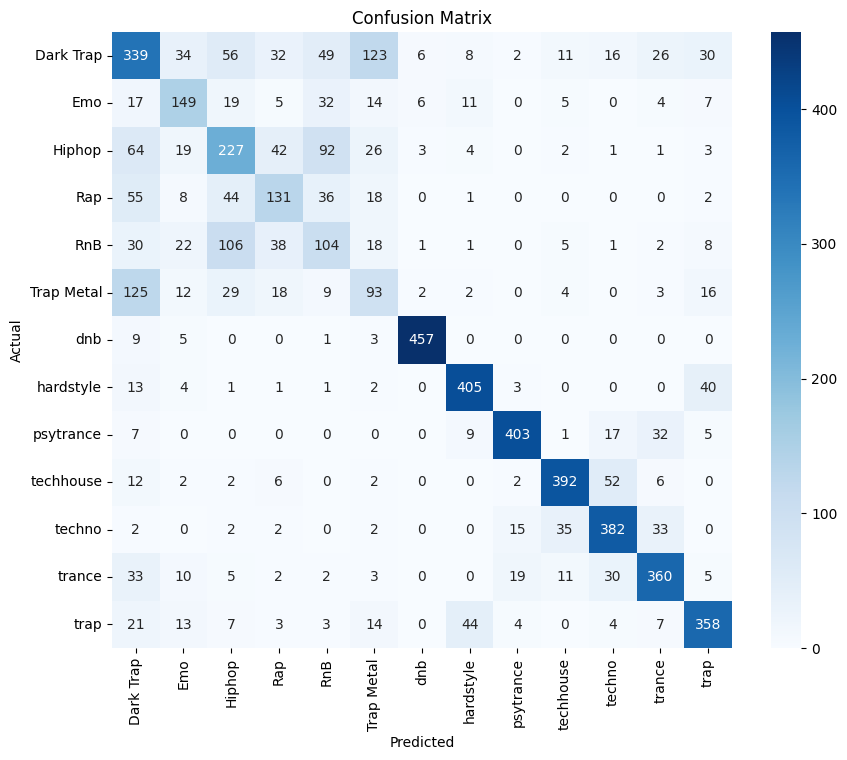

In [120]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
report(y_val, pred_val, label_encoder)

accuracy score: 0.6638865721434529
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       916
           1       0.53      0.51      0.52       336
           2       0.47      0.49      0.48       606
           3       0.44      0.40      0.42       370
           4       0.34      0.34      0.34       420
           5       0.32      0.32      0.32       391
           6       0.97      0.96      0.97       593
           7       0.81      0.85      0.83       587
           8       0.90      0.86      0.88       592
           9       0.85      0.85      0.85       595
          10       0.76      0.79      0.77       591
          11       0.76      0.77      0.76       600
          12       0.79      0.77      0.78       597

    accuracy                           0.66      7194
   macro avg       0.65      0.64      0.64      7194
weighted avg       0.66      0.66      0.66      7194



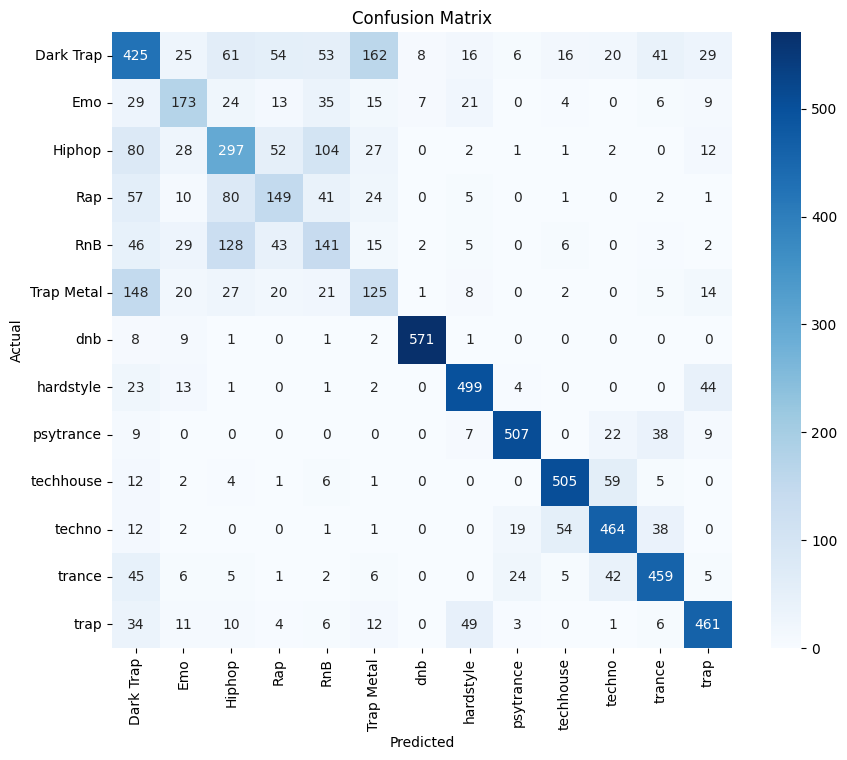

In [121]:
pred_test = model.predict(X_test)
report(y_test, pred_test, label_encoder)

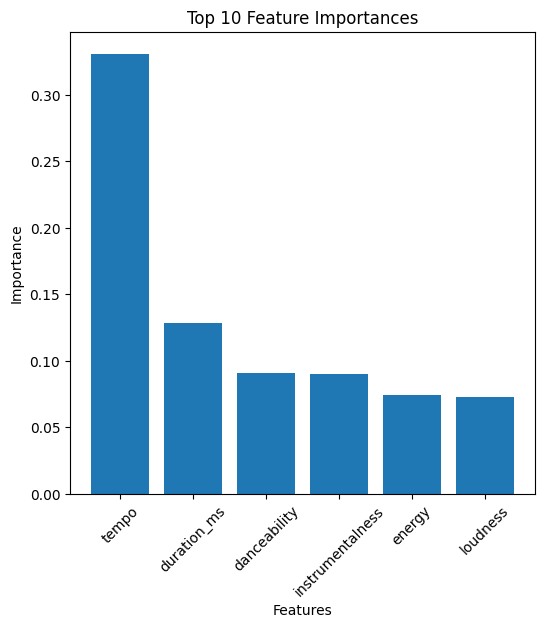

In [122]:
importances = model.feature_importances_
feature_names = df_x.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 6))
plt.bar(range(6), importances[sorted_idx[:6]], align='center')
plt.xticks(range(6), [feature_names[i] for i in sorted_idx[:6]], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()

넓은 분포를 차지하는 UndergroundRap과 Pop 두개를 다 삭제한 것이 헷갈리지 않게 하여 더 좋은 성능을 보이긴한다.

이건 적용시켜도 괜찮지 않을까?


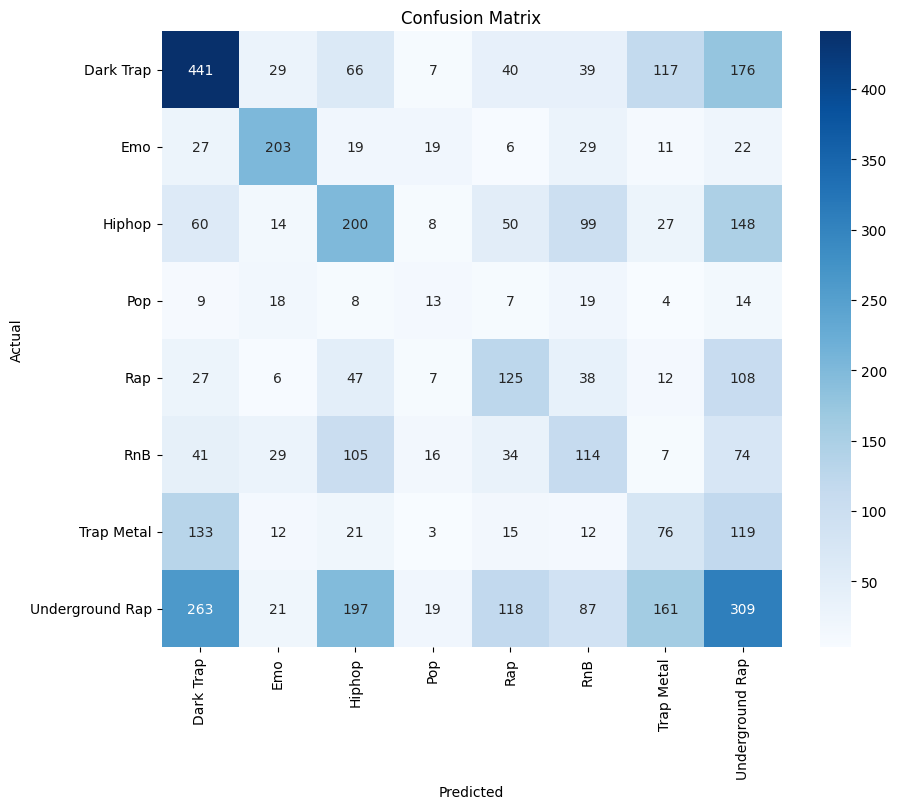

0번부터 7번 클래스만 학습했을 때

## 클래스 합치기

In [7]:
file_path = "./input/genres_v2.csv"

df = pd.read_csv(file_path, low_memory=False)
df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title', 'key', 'mode', 'time_signature'], axis=1)

df_y = df['genre']
df_x = df.drop(['genre'], axis=1)

label_encoder = LabelEncoder()

df_y_encoded = label_encoder.fit_transform(df_y)

original_labels = label_encoder.classes_

df_y = df_y_encoded

z_scores = np.abs(zscore(df_x))

threshold = 3
outliers = np.where(z_scores > threshold)

outliers_indices = np.unique(outliers[0])
df_x_imputed = df_x.copy()

for idx in outliers_indices:
    class_label = df_y[idx]
    df_x_imputed.iloc[idx] = df_x[df_y == class_label].mean()

### 유사도

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

df_x['genre'] = df_y
genre_means = df_x.groupby('genre').mean()

genre_means = pd.DataFrame(df_x, columns=df_x.columns[:-1]).groupby(df_y).mean()

cos_sim_matrix = cosine_similarity(genre_means)
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=genre_means.index, columns=genre_means.index)

similar_genres = cos_sim_df.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
print(similar_genres)

0         [0, 7, 3, 2, 1]
1         [1, 5, 2, 3, 9]
2         [2, 3, 1, 5, 9]
3         [3, 2, 1, 5, 9]
4        [4, 8, 9, 14, 5]
5         [5, 1, 2, 3, 9]
6         [6, 7, 0, 3, 2]
7         [7, 0, 6, 3, 2]
8        [8, 4, 14, 9, 5]
9        [9, 14, 4, 5, 1]
10    [10, 12, 11, 13, 8]
11    [11, 13, 12, 10, 8]
12    [12, 10, 11, 13, 8]
13    [13, 11, 8, 12, 10]
14       [14, 9, 4, 5, 8]
dtype: object


### 0부터 7, 8부터 14개 클래스 묶기

In [9]:
group = [1, 2, 3, 4, 5, 6, 7]
group2 = [9, 10, 11, 12, 13, 14]

file_path = "./input/genres_v2.csv"
df = pd.read_csv(file_path, low_memory=False)
df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title', 'key', 'mode', 'time_signature'], axis=1)

df_y = df['genre']
df_x = df.drop(['genre'], axis=1)

label_encoder = LabelEncoder()
df_y_encoded = label_encoder.fit_transform(df_y)
df_y = pd.Series(df_y_encoded)
original_labels = label_encoder.classes_

df_y = df_y.apply(lambda x: 0 if x in group else x)
df_y = df_y.apply(lambda x: 8 if x in group2 else x)

z_scores = np.abs(zscore(df_x))
threshold = 3
outliers = np.where(z_scores > threshold)
outliers_indices = np.unique(outliers[0])
df_x_imputed = df_x.copy()

for idx in outliers_indices:
    class_label = df_y[idx]
    df_x_imputed.iloc[idx] = df_x[df_y == class_label].mean()


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, shuffle=True, random_state=1, stratify=df_y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1, stratify=y_train)

In [11]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
pred_val = model.predict(X_val)

accuracy score: 0.936179642487812
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3444
           8       0.94      0.93      0.93      3325

    accuracy                           0.94      6769
   macro avg       0.94      0.94      0.94      6769
weighted avg       0.94      0.94      0.94      6769



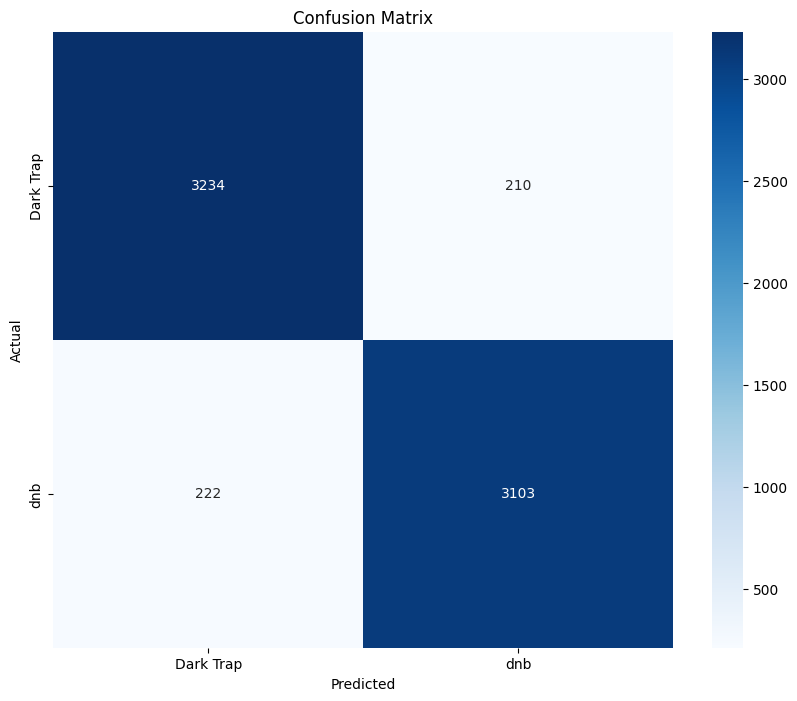

In [12]:
report(y_val, pred_val, label_encoder)

accuracy score: 0.9373596501595556
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4305
           8       0.93      0.94      0.94      4156

    accuracy                           0.94      8461
   macro avg       0.94      0.94      0.94      8461
weighted avg       0.94      0.94      0.94      8461



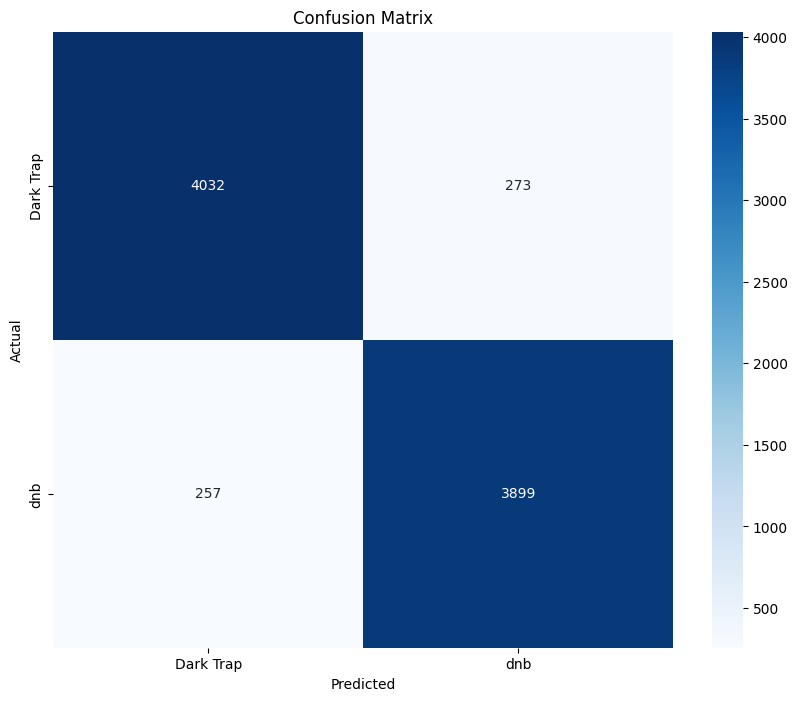

In [13]:
pred_test = model.predict(X_test)
report(y_test, pred_test, label_encoder)

서로간에 헷갈리는 클래스가 엄청나게 많은게 아닌거보면 이렇게 묶인게 비슷한 애들인 것 같다.

### 0부터 7까지 클래스 묶기

In [ ]:
group = [1, 2, 3, 4, 5, 6, 7]

file_path = "./input/genres_v2.csv"
df = pd.read_csv(file_path, low_memory=False)
df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title', 'key', 'mode', 'time_signature'], axis=1)

df_y = df['genre']
df_x = df.drop(['genre'], axis=1)

label_encoder = LabelEncoder()
df_y_encoded = label_encoder.fit_transform(df_y)
df_y = pd.Series(df_y_encoded)
original_labels = label_encoder.classes_

df_y = df_y.apply(lambda x: 0 if x in group else x)

z_scores = np.abs(zscore(df_x))
threshold = 3
outliers = np.where(z_scores > threshold)
outliers_indices = np.unique(outliers[0])
df_x_imputed = df_x.copy()

for idx in outliers_indices:
    class_label = df_y[idx]
    df_x_imputed.iloc[idx] = df_x[df_y == class_label].mean()

print(df_x_imputed.head())

   danceability  energy  loudness  speechiness  acousticness  \
0         0.831   0.814    -7.364       0.4200        0.0598   
1         0.719   0.493    -7.230       0.0794        0.4010   
2         0.850   0.893    -4.783       0.0623        0.0138   
3         0.476   0.781    -4.710       0.1030        0.0237   
4         0.798   0.624    -7.668       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  
0          0.013400    0.0556   0.3890  156.985     124539.0  
1          0.000000    0.1180   0.1240  115.080     224427.0  
2          0.000004    0.3720   0.0391  218.050      98821.0  
3          0.000000    0.1140   0.1750  186.948     123661.0  
4          0.000000    0.1660   0.5910  147.988     123298.0  


In [15]:
df_y.unique()

array([ 0, 11, 12, 13, 10, 14,  8,  9], dtype=int64)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, shuffle=True, random_state=1, stratify=df_y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1, stratify=y_train)

In [17]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
pred_val = model.predict(X_val)

accuracy score: 0.8782685773378638
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3444
           8       0.93      0.97      0.95       474
           9       0.82      0.81      0.82       470
          10       0.87      0.86      0.86       474
          11       0.81      0.86      0.83       476
          12       0.80      0.78      0.79       473
          13       0.75      0.72      0.73       480
          14       0.76      0.74      0.75       478

    accuracy                           0.88      6769
   macro avg       0.83      0.83      0.83      6769
weighted avg       0.88      0.88      0.88      6769



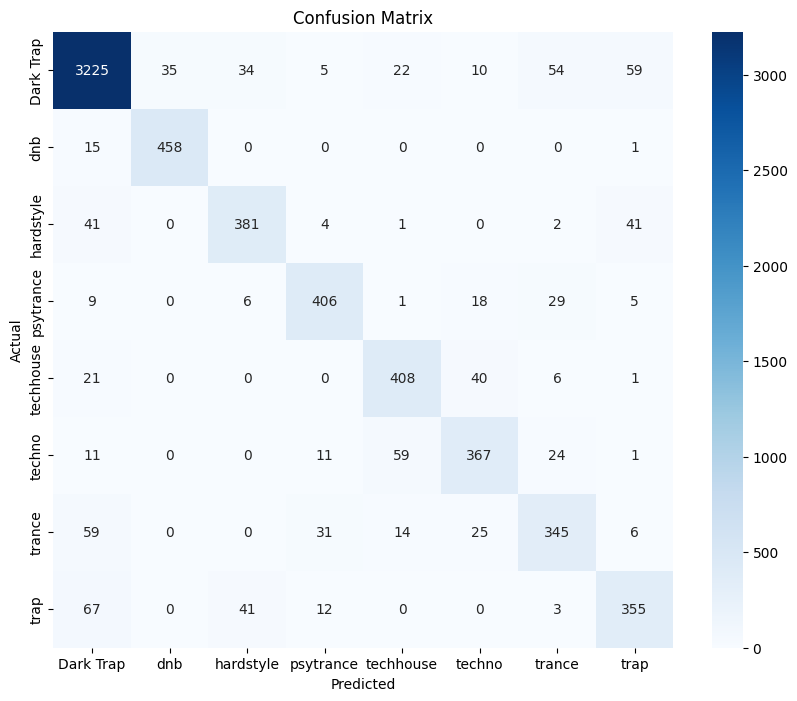

In [18]:
report(y_val, pred_val, label_encoder)

accuracy score: 0.8850017728400899
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4305
           8       0.96      0.95      0.95       593
           9       0.85      0.82      0.83       587
          10       0.88      0.88      0.88       592
          11       0.84      0.88      0.86       595
          12       0.78      0.76      0.77       591
          13       0.75      0.73      0.74       600
          14       0.79      0.76      0.78       598

    accuracy                           0.89      8461
   macro avg       0.85      0.84      0.84      8461
weighted avg       0.88      0.89      0.88      8461



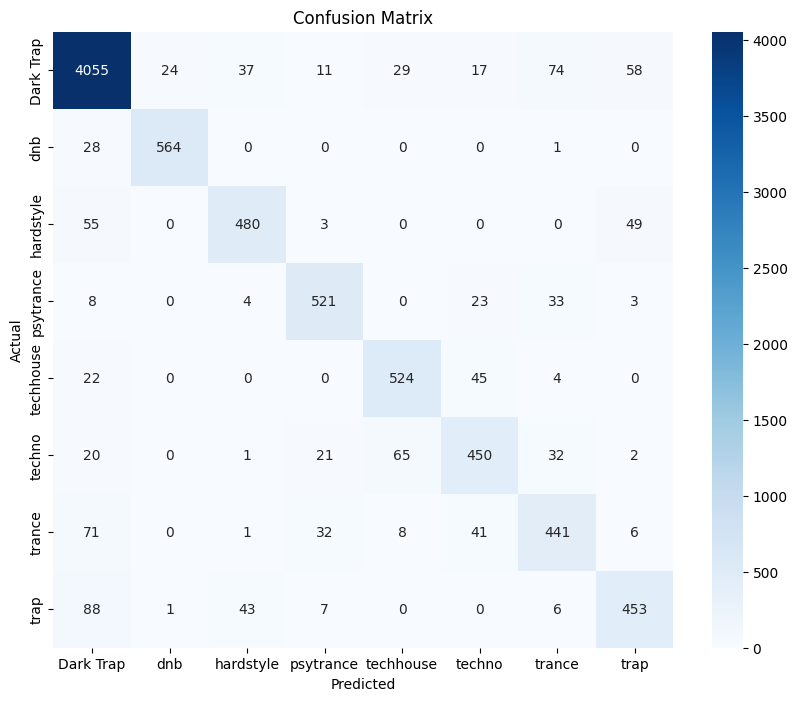

In [19]:
pred_test = model.predict(X_test)
report(y_test, pred_test, label_encoder)

0부터 7까지 합치는 것도 괜찮은 것 같음